In [1]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import pandas as pd
import math
import gtsam
import json

import matplotlib
import matplotlib.pyplot as plt
import gtsam.utils.plot as gtsam_plot

from vehicle_lib.numpy_helper import np_normalize_angle_mpi_to_pi, rotate_vector_2d
from landmark_tracking_helper import simulate_odometry_and_GPS, simulate_landmarks_sesing, Plots

# Basic example to Simultaneous Localization and Mapping (SLAM) for a single vehicle

A basic SLAM application is considered. Herein, a single vehicle follows an unknow path passing by multiple landmarks. The positions of these landmarks are further unknown. The vehicle is equipped with sensors to measure 

* an approximate absolute position subjected to (Gaussian) noise, e.g., GPS,
* the relative movement of the vehicle as described by the velocity and yaw rate (odometry), and
* the bearing angle and distance between the vehicle body and possibly multiple landmarks.

Herein, the rate of the readings from GPS is less compared to the odometry. Further, it is assumed that all readings are subjected to Gaussian noise with known covariance parameters. Estimates for the landmark positions and the vehicle trajectory shall be derived given these measurements. Therefore, the motion model of the vehicle and models for the sensor measurements are connected in a factor graph. the unknown estimates are then determined by a nonlinear least squares procedure.

## Load a trace

This trace was produced by a vehicle model as serves as ground truth (unknown to the estimation algorithm).

In [2]:
with open('data/path_to_goal_2.json') as json_file:
    raw_trace = json.load(json_file)

## Define landmark positions

In [3]:
# define landmark ground truth
pdf_landmarks_ground_truth = pd.DataFrame()

pdf_landmarks_ground_truth["landmark_id"] = np.array( [1,    2,      3], dtype=np.int64 )
pdf_landmarks_ground_truth["x"]           = np.array( [10.0, 9.0, 20.0], dtype=np.float64 )
pdf_landmarks_ground_truth["y"]           = np.array( [0.0,  5.0, 10.0], dtype=np.float64 )
pdf_landmarks_ground_truth

,landmark_id,x,y
0,1,10.0,0.0
1,2,9.0,5.0
2,3,20.0,10.0


# Generate measurement data via simulation

## Simulate the sensors for localisation of vehicle

Herein, the vehicle odometry and GPS are modelled and simulated yielding a trace of bearing measurements and GPS positions/headings.


In [4]:
pdf_odometry_measurements, pdf_gps_measurements, pdf_vehicle_trace_gt = simulate_odometry_and_GPS(
    raw_trace, number_of_samples=100, number_of_gps_samples=8,
    xy_gps_sigma  = math.sqrt( 1.0 ),
    psi_gps_sigma = math.sqrt( 0.1 ),
)

In [5]:
#pdf_vehicle_trace_gt

In [6]:
#pdf_odometry_measurements

In [7]:
#pdf_gps_measurements

## Simulate the bearing/distance measurement of landmarks

In [8]:
# Simulate landmark observations
pdf_landmarks_bearing = simulate_landmarks_sesing(pdf_vehicle_trace_gt, pdf_landmarks_ground_truth)
#pdf_landmarks_bearing

## Plot the visibility of the landmarks

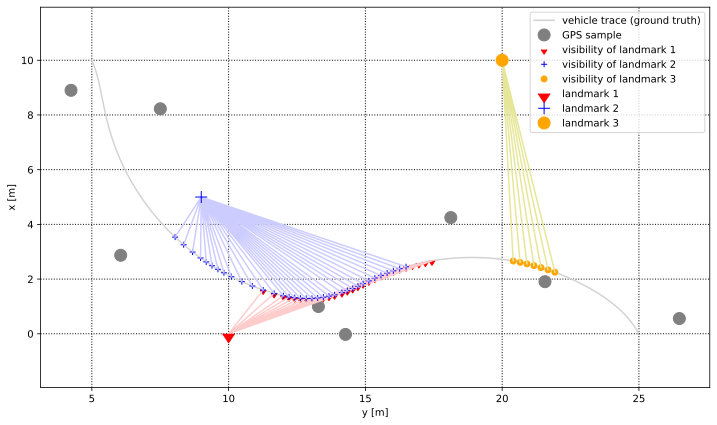

In [9]:
landmarks_to_show = [
    [1, "red",    (1.0, 0.8, 0.8), matplotlib.markers.CARETDOWNBASE ],
    [2, "blue",   (0.8, 0.8, 1.0), "+"],
    [3, "orange", (0.9, 0.9, 0.6), "o"],
]
Plots.plot_overview(pdf_vehicle_trace_gt, pdf_gps_measurements, pdf_landmarks_ground_truth, pdf_landmarks_bearing, landmarks_to_show, figsize=(12, 7))

## Set-up the factor graph

In [10]:
# number of vehicle-pose nodes
n_X_nodes = pdf_vehicle_trace_gt.shape[0]
n_X_nodes

100

In [11]:
def generate_node_id_from_landmark_id(landmark_ids : np.ndarray, n_X_nodes : int) -> np.ndarray:
    # Add ofs for landmark ids
    # Technically this is not needed, however, the ids for landmarks become clearly visible in the prints of the tables.
    LANDMARK_ID_OFS = 1000
    
    node_id = np.array(landmark_ids, dtype=np.int64)  + 1 + n_X_nodes  + LANDMARK_ID_OFS
    return node_id

In [12]:
# find all landmarks
# This might be replaced by an clustering algortithm
landmark_ids = pdf_landmarks_bearing["landmark_id"].unique()     

pdf_landmarks = pd.DataFrame()
pdf_landmarks["landmark_id"] = np.array(landmark_ids, dtype=np.int64)
pdf_landmarks["x_init"]      = math.nan # not filled yet
pdf_landmarks["y_init"]      = math.nan

pdf_landmarks["node_id"]     = generate_node_id_from_landmark_id(landmark_ids, n_X_nodes) # np.array(landmark_ids, dtype=np.int64)  + 1 + n_X_nodes  + LANDMARK_ID_OFS

pdf_landmarks

,landmark_id,x_init,y_init,node_id
0,1,NaN,NaN,1102
1,2,NaN,NaN,1103
2,3,NaN,NaN,1104


In [13]:
# generate node ids for the GPS prior nodes
pdf_gps_measurements["node_id"] = pdf_gps_measurements.index_in_trace + 1
pdf_gps_measurements

,x,y,psi,index_in_trace,x_sigma,y_sigma,psi_sigma,node_id
0,26.477978,0.557671,2.112124,1,1.0,1.0,0.316228,2
1,21.565927,1.904642,2.485713,15,1.0,1.0,0.316228,16
2,18.122688,4.248713,3.188064,29,1.0,1.0,0.316228,30
3,14.271919,-0.023060,3.747931,43,1.0,1.0,0.316228,44
4,13.282317,0.997134,2.671572,57,1.0,1.0,0.316228,58
5,6.054188,2.870388,2.788075,71,1.0,1.0,0.316228,72
6,7.503783,8.225590,2.176498,85,1.0,1.0,0.316228,86
7,4.238793,8.900109,2.140856,99,1.0,1.0,0.316228,100


In [14]:
pdf_odometry_measurements["node_id_src"]  = pdf_odometry_measurements.index + 1
pdf_odometry_measurements["node_id_dest"] = pdf_odometry_measurements.index + 2
pdf_odometry_measurements

,d_delta,psi_delta,d_sigma,psi_sigma,node_id_src,node_id_dest
0,0.209977,0.054803,0.01,0.01,1,2
1,0.209974,0.058460,0.01,0.01,2,3
2,0.209971,0.062101,0.01,0.01,3,4
3,0.209967,0.065715,0.01,0.01,4,5
4,0.209963,0.057657,0.01,0.01,5,6
...,...,...,...,...,...,...
94,0.209997,0.022870,0.01,0.01,95,96
95,0.209989,0.037808,0.01,0.01,96,97
96,0.209987,0.041411,0.01,0.01,97,98
97,0.209985,0.045044,0.01,0.01,98,99


In [15]:
pdf_landmarks_bearing["node_id_src"] = pdf_landmarks_bearing.index_in_trace_where_landmark_was_seen + 1

pdf_landmarks_bearing["node_id_dest"] = generate_node_id_from_landmark_id(pdf_landmarks_bearing.landmark_id, n_X_nodes) # pdf_landmarks_bearing.landmark_id + 1 + n_X_nodes  + LANDMARK_ID_OFS
pdf_landmarks_bearing

,landmark_id,index_in_trace_where_landmark_was_seen,bearing_angle,bearing_distance,bearing_angle_sigma,bearing_distance_sigma,node_id_src,node_id_dest
0,1,34,0.171674,7.896670,0.01,0.4,35,1102
1,1,35,0.149028,7.656185,0.01,0.4,36,1102
2,1,36,0.125928,7.416039,0.01,0.4,37,1102
3,1,37,0.102208,7.175155,0.01,0.4,38,1102
4,1,38,0.077799,6.933649,0.01,0.4,39,1102
...,...,...,...,...,...,...,...,...
2,3,18,-1.098931,7.711854,0.01,0.4,19,1104
3,3,19,-1.161027,7.596353,0.01,0.4,20,1104
4,3,20,-1.223546,7.497585,0.01,0.4,21,1104
5,3,21,-1.285351,7.416694,0.01,0.4,22,1104


In [16]:
# Put the initial estimates for the vehicle poses
# NoTE: here actually the GT is filled, TODO: repalce with pre-estimates OR
# at least add noise

pdf_vehicle_trace_initial_estimate = pdf_vehicle_trace_gt.copy()

pdf_vehicle_trace_initial_estimate["node_id"] = np.arange(0, pdf_vehicle_trace_initial_estimate.shape[0] ) + 1
pdf_vehicle_trace_initial_estimate

,x,y,psi,node_id
0,24.965000,0.060622,2.111848,1
1,24.853632,0.238632,2.166651,2
2,24.732474,0.410125,2.225111,3
3,24.601305,0.574083,2.287212,4
4,24.460029,0.729413,2.352927,5
...,...,...,...,...
95,5.271301,9.132772,1.791949,96
96,5.222715,9.337063,1.829757,97
97,5.166200,9.539302,1.871167,98
98,5.101121,9.738947,1.916211,99


In [17]:
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()
    
# add GPS measurements
for gps_sample in pdf_gps_measurements.itertuples():
    
    gps_noise = gtsam.noiseModel.Diagonal.Sigmas( 
        np.array( [ gps_sample.x_sigma, gps_sample.y_sigma, gps_sample.psi_sigma ] )     
    )

    prior_mean = gtsam.Pose2( gps_sample.x, gps_sample.y, gps_sample.psi )
    graph.add(gtsam.PriorFactorPose2(gps_sample.node_id, prior_mean, gps_noise))

    
# build odometry chain  
for odom_sample in pdf_odometry_measurements.itertuples():
    odometry = gtsam.Pose2( odom_sample.d_delta, 0.0, odom_sample.psi_delta )

    odometry_noise = gtsam.noiseModel.Diagonal.Sigmas(
        np.array([odom_sample.d_sigma, 0.0, odom_sample.psi_sigma]) 
    )
    
    graph.add(gtsam.BetweenFactorPose2(
        odom_sample.node_id_src, odom_sample.node_id_dest,
        odometry,
        odometry_noise
    ))  
      
    

# add the factors for the landmarks     
for bearing_sample in pdf_landmarks_bearing.itertuples():
 
    landmark_id            = bearing_sample.landmark_id
    seen_at_index_in_trace = bearing_sample.index_in_trace_where_landmark_was_seen
    bearing_angle          = bearing_sample.bearing_angle
    bearing_distance       = bearing_sample.bearing_distance

    bearing_noise  = gtsam.noiseModel.Diagonal.Sigmas( 
        np.array([bearing_sample.bearing_angle_sigma, bearing_sample.bearing_distance_sigma]) 
    )

    
    # add node
    graph.add( gtsam.BearingRangeFactor2D( 
        bearing_sample.node_id_src, bearing_sample.node_id_dest,
        gtsam.Rot2.fromAngle( bearing_angle ), 
        bearing_distance, bearing_noise ) 
    )

    
    # estimate an initial value for the position of the landmark; 
    # use the the 'seen from' position + the bearing vector
    
    vehicle_trace_sample = pdf_vehicle_trace_gt.iloc[seen_at_index_in_trace]
    
    xy_vehicle  = np.array([vehicle_trace_sample.x, vehicle_trace_sample.y])
    psi_vehicle = vehicle_trace_sample.psi
    
    alpha = bearing_angle + psi_vehicle
    
    xy_l = rotate_vector_2d( alpha, np.array([1.0, 0.0]) ) * bearing_distance + xy_vehicle +    np.array([1.3, 0.6])  # add some error
    
    # fill in a rough estimate for the position of the landmark, TODO: update/iterative average
    index = pdf_landmarks[ pdf_landmarks.landmark_id == landmark_id ].index[0] 
    pdf_landmarks.loc[index, ["x_init","y_init"]] = xy_l
    

    
# fill initial values for the poses
for sample in pdf_vehicle_trace_initial_estimate.itertuples():
    initial.insert(sample.node_id, gtsam.Pose2( sample.x, sample.y, sample.psi ))
    
# initialise landmark initial values
for landmark in pdf_landmarks.itertuples():    
    initial.insert(landmark.node_id,  gtsam.Point2( landmark.x_init, landmark.y_init )  )
    

In [18]:
# plot the landmarks and their initial estimates
pdf_landmarks

,landmark_id,x_init,y_init,node_id
0,1,11.3,0.6,1102
1,2,10.3,5.6,1103
2,3,21.3,10.6,1104


## Run the optimisation

In [19]:
# optimize using Levenberg-Marquardt optimization
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
result = optimizer.optimize()
#print("\nFinal Result:\n{}".format(result))


In [20]:
# 5. Calculate and print marginal covariances for all variables
marginals = gtsam.Marginals(graph, result)
for i in range(1, 2):
    print("X{} covariance:\n{}\n".format(i, marginals.marginalCovariance(i)))


X1 covariance:
[[ 0.2343347  -0.12320351  0.01543065]
 [-0.12320351  0.2761633  -0.02031341]
 [ 0.01543065 -0.02031341  0.00408594]]



## Show the results

The resulting estimates for the vehicle trajectory and the positions of the landmarks is shown. Further, the ellipses illustrate the covariances of the estimates (a Gaussian distribution is assumed)

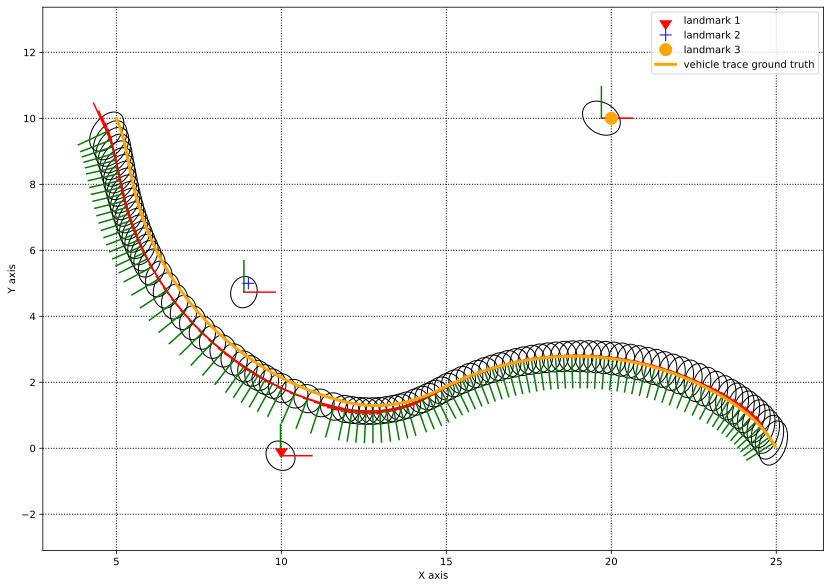

In [21]:
fig = plt.figure(0, figsize=(14,10), dpi=100)
for i in range(n_X_nodes):
    gtsam_plot.plot_pose2(0, result.atPose2(i+1), 0.95, marginals.marginalCovariance(i+1))
    

for landmark in pdf_landmarks.itertuples():
    xy = result.atPoint2(landmark.node_id)
    gtsam_plot.plot_pose2(0, gtsam.Pose2( xy[0], xy[1], 0.0 ), 0.95, marginals.marginalCovariance(landmark.node_id) )

    
Plots.for_each_landmark(pdf_vehicle_trace_gt, pdf_landmarks_bearing, pdf_landmarks_ground_truth, landmarks_to_show, Plots.add_plot_landmark_markers)
plt.plot( pdf_vehicle_trace_gt.x, pdf_vehicle_trace_gt.y, color="orange", linewidth=3 ,label="vehicle trace ground truth" )

plt.axis('equal')
plt.grid(color='k', linestyle=':', linewidth=1)
plt.legend(loc='best')
plt.show()